<a href="https://colab.research.google.com/github/carlogattuso/Indoor_Positioning_RTT_GPR/blob/master/ap_obs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
################ Library imports ################
import numpy as np
import math as math
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import scipy.linalg
import seaborn as sns
import time
import glob
import pandas as pd

import itertools

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, WhiteKernel

from sklearn.metrics import mean_squared_error, mean_absolute_error
 
from scipy.optimize import curve_fit

from IPython.display import display, Markdown, clear_output
import ipywidgets as widgets

In [28]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


#Dataset Reading

In [29]:
"""
File reading
"""
training = pd.read_csv('/content/drive/MyDrive/GPR/data/Meas_Sala_Actos/SalaActos_New_Large_Todos.csv', sep = ",", index_col=False, encoding='latin-1')
validation = pd.read_csv('/content/drive/MyDrive/GPR/data/Meas_Sala_Actos/SalaActos_New_Todos.csv', sep = ",", index_col=False, encoding='latin-1')
df = pd.concat([training, validation])
df = df.replace(to_replace = -100, value = np.nan)
df.head()

,batch,x,y,z,brand,model,angle,sampleNumber,30:23:03:87:17:80#1,30:23:03:87:17:81#1,30:23:03:87:17:82#1,30:23:03:87:17:98#1,30:23:03:87:17:99#1,30:23:03:87:17:9a#1,30:23:03:87:19:6c#1,30:23:03:87:19:6d#1,30:23:03:87:19:6e#1,36:23:03:87:17:80#1,36:23:03:87:17:98#1,36:23:03:87:19:6c#1,58:cb:52:d7:b4:d9#1,58:cb:52:d7:b5:31#1,58:cb:52:d7:b5:5d#1,58:cb:52:d7:bb:61#1,c4:41:1e:fa:08:88#1,c4:41:1e:fa:08:89#1,c4:41:1e:fa:08:8a#1,ca:41:1e:fa:08:88#1
0,03c6987c93bc9a98235fa5af2ccd5bb7,0.0,8.0,0.0,google,Pixel 3a,0.0,11,16.020,2.979,2.904,23.520,9.641,8.920,36.523,20.278,17.767,NaN,NaN,NaN,17.233,7.286,-0.570,16.989,24.326,6.644,5.204,NaN
1,03c6987c93bc9a98235fa5af2ccd5bb7,0.0,8.0,0.0,google,Pixel 3a,0.0,12,17.257,2.694,2.728,23.344,9.804,8.803,35.107,20.276,17.865,NaN,NaN,NaN,17.229,7.301,-0.588,17.026,24.223,6.626,5.145,NaN
2,03c6987c93bc9a98235fa5af2ccd5bb7,0.0,8.0,0.0,google,Pixel 3a,0.0,13,16.488,2.857,2.650,23.398,9.729,8.607,35.382,20.362,17.806,NaN,NaN,NaN,17.423,7.220,-0.551,16.989,23.866,6.566,5.145,NaN
3,03c6987c93bc9a98235fa5af2ccd5bb7,0.0,8.0,0.0,google,Pixel 3a,0.0,14,14.445,2.651,2.846,23.041,9.854,8.842,35.694,20.395,17.767,NaN,NaN,NaN,17.342,7.223,-0.513,17.167,23.623,6.526,5.072,NaN
4,03c6987c93bc9a98235fa5af2ccd5bb7,0.0,8.0,0.0,google,Pixel 3a,0.0,15,12.882,2.970,2.982,23.970,9.929,8.646,36.157,20.367,17.982,NaN,NaN,NaN,17.583,6.969,-0.321,16.914,23.970,6.644,5.189,24.57


#Radio-map definition

In [30]:
"""
Scenario size
"""
width = 8
height = 19.2

points_x = 5
points_y = 5

n_points = points_x * points_y

"""
Locations grid
"""
locations = np.array(np.meshgrid(np.linspace(0, height, points_y).round(3), np.linspace(0, width, points_x).round(3))).T.reshape(-1,2)
locations[:, [1, 0]] = locations[:, [0, 1]]

"""
Plot coordinates
"""
coordinates = np.array(np.meshgrid(np.linspace(0, points_x - 1, points_x), np.linspace(0, points_y - 1, points_y))).T.reshape(-1,2)
coordinates[:, [1, 0]] = coordinates[:, [0, 1]]

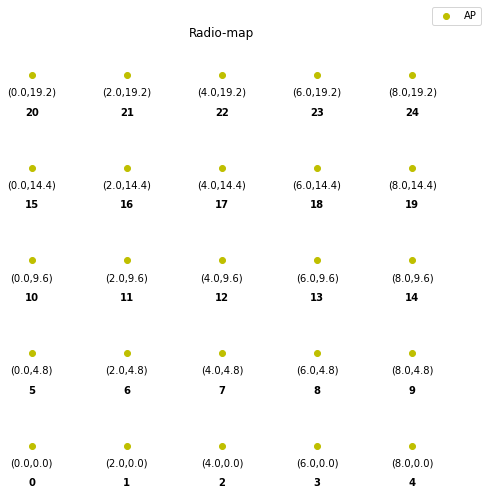

In [31]:
#@title ##Radio-map plot
plt.figure(figsize=(points_y*1.5, points_x*1.5))

plt.scatter(coordinates[:,0], coordinates[:,1], c='y')

plt.legend(labels=['AP','VRP'],loc="upper right",borderaxespad=-5)
plt.title('Radio-map',pad=20)
plt.axis('off')

for x,y,z in zip(coordinates[:,0],coordinates[:,1], np.linspace(0, n_points - 1, n_points).astype(int)):
    label = f"({locations[z,0]},{locations[z,1]})"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-20), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

    label = f"{z}"

    plt.annotate(label, # this is the text
                  (x,y), # this is the point to label
                  textcoords="offset points", # how to position the text
                  xytext=(0,-40), # distance from text to points (x,y)
                  ha='center',
                  weight='bold') # horizontal alignment can be left, right or center

#AP definition

##AP class

### Handles the required parameters for each AP

####Parameters:

*   name (string)
*   x (number)
*   y (number)
*   point (number)


In [32]:
class AP:
    '''
 
    '''
    def __init__(self, _name, _x, _y, _point, _mac):
        self.name = _name
        self.x = _x
        self.y = _y
        self.point = _point
        self.mac = _mac

##Create APs

In [33]:
ap_list = []

ap_list.append(AP('Google Blanco', 0, 19.2, 20, '58:cb:52:d7:b4:d9#1'))

ap_list.append(AP('Google Azul', 0, 0, 0, '58:cb:52:d7:b5:31#1'))

#ap_list.append(AP('Linksys 1', 4, 0, 2, '30:23:03:87:17:80#1'))

ap_list.append(AP('Google Verde', 8, 0, 4, '58:cb:52:d7:b5:5d#1'))

#ap_list.append(AP('Linksys 2', 0, 9.6, 10, '30:23:03:87:17:98#1'))

ap_list.append(AP('Google Rojo', 8.0, 19.2, 24, '58:cb:52:d7:bb:61#1'))

#ap_list.append(AP('Linksys 3', 4, 19.2, 22, '30:23:03:87:19:6c#1'))

#ap_list.append(AP('Linksys 4', 8, 9.6, 14, 'c4:41:1e:fa:08:88#1'))

##Sort APs by location

In [34]:
ap_labels = {}
ap_indexes = {}
ap_mac = []

"""
Sorting AP list
"""
ap_list.sort(key=lambda x: x.point)

print("List of Access Points: \n\n")
points = []
for i in range(len(ap_list)):
  points.append(ap_list[i].point)
  ap_labels[i]=ap_list[i].name
  ap_indexes[str(ap_list[i].name)]=i
  ap_mac.append(ap_list[i].mac)
  print(ap_list[i].name,'-->',' x: ',ap_list[i].x,' y: ', 
        ap_list[i].y, ' point: ', ap_list[i].point, '\n')

print('\nAP Points: ', points, '\n\n')
print("MAC Address List: \n\n")
print(ap_mac)

List of Access Points: 


Google Azul -->  x:  0  y:  0  point:  0 

Google Verde -->  x:  8  y:  0  point:  4 

Google Blanco -->  x:  0  y:  19.2  point:  20 

Google Rojo -->  x:  8.0  y:  19.2  point:  24 


AP Points:  [0, 4, 20, 24] 


MAC Address List: 


['58:cb:52:d7:b5:31#1', '58:cb:52:d7:b5:5d#1', '58:cb:52:d7:b4:d9#1', '58:cb:52:d7:bb:61#1']


##Final Scenario 

In [35]:
"""
AP locations
"""
L_ap = locations[points,:]

"""
VRP locations
"""
L_vrp = np.delete(locations, points, 0)

n_ap = len(ap_list)
n_vrp = n_points - n_ap

"""
Plot coordinates
"""
coordinates = np.array(np.meshgrid(np.linspace(0, points_x - 1, points_x), np.linspace(0, points_y - 1, points_y))).T.reshape(-1,2)
coordinates[:, [1, 0]] = coordinates[:, [0, 1]]

coordinates_ap = coordinates[points,:]

coordinates_vrp = np.delete(coordinates, points, 0)

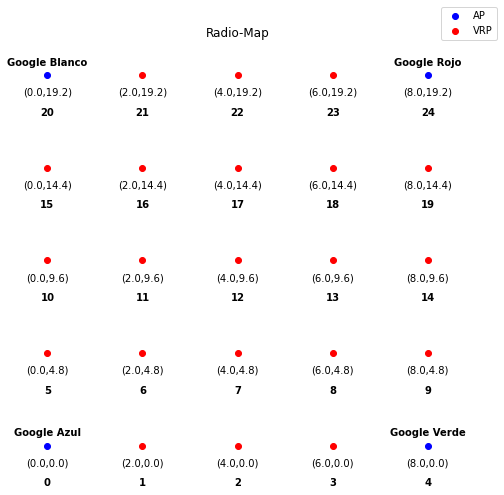

In [36]:
#@title ##Scenario Plot
plt.figure(figsize=(points_y*1.5, points_x*1.5))

plt.scatter(coordinates_ap[:,0], coordinates_ap[:,1], c='b')
plt.scatter(coordinates_vrp[:,0], coordinates_vrp[:,1], c='r')

plt.legend(labels=['AP','VRP'],loc="upper right",borderaxespad=-5)
plt.title('Radio-Map',pad=20)
plt.axis('off')

for x,y,z in zip(coordinates[:,0],coordinates[:,1], np.linspace(0, n_points - 1, n_points).astype(int)):
    label = f"({locations[z,0]},{locations[z,1]})"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-20), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

    label = f"{z}"

    plt.annotate(label, # this is the text
                  (x,y), # this is the point to label
                  textcoords="offset points", # how to position the text
                  xytext=(0,-40), # distance from text to points (x,y)
                  ha='center',
                  weight='bold') # horizontal alignment can be left, right or center

for x,y,z in zip(coordinates_ap[:,0],coordinates_ap[:,1], np.linspace(0, n_ap - 1, n_ap).astype(int)):
    label = f"{ap_labels[z]}"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center', # horizontal alignment can be left, right or center
                 weight='bold')

#RTT Observations among APs

In [37]:
"""
Dataset split
    - ap_obs --> RTT observations between APs

We are getting RTT observations from dataset, splitting AP and VRP samples
"""
ap_obs = np.empty((n_ap, n_ap, 100))

df.sort_values(ap_mac)
for count, row in enumerate(L_ap):
  if row[0] == 8.0 and row[1] == 19.2:
    row[0] = 8.1
  aux = df.loc[(df['y'] == row[0]) & (df['x'] == row[1])]
  aux = aux[ap_mac].values
  aux = aux.T
  ap_obs[count,:,:] = aux

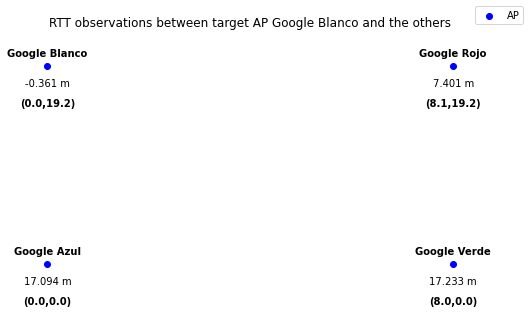

In [38]:
#@title ##Observations plot
ap_selected = "Google Blanco"  #@param ['Google Blanco', 'Linksys 1', 'Google Azul', 'Linksys 2', 'Google Rojo', 'Linksys 3', 'Google Verde']
sample = 0 #@param {type:"slider", min:0, max:100, step:1}

try:
  ap_indexes[ap_selected]
except:
  ap_selected = ap_labels[0]
  
plt.figure(figsize=(8,4))

plt.scatter(coordinates_ap[:,0], coordinates_ap[:,1], c='b')

plt.legend(labels=['AP'],loc="upper right",borderaxespad=-5)
plt.title('RTT observations between target AP '+ap_selected+' and the others',pad=30)
plt.axis('off')

for x,y,z in zip(coordinates_ap[:,0], coordinates_ap[:,1], ap_obs[:,int(ap_indexes[ap_selected]),sample]):
    label = f"{z.round(3)} m"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-20), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

for x,y,z in zip(coordinates_ap[:,0],coordinates_ap[:,1], np.linspace(0, n_ap - 1, n_ap).astype(int)):

    label = f"{ap_labels[z]}"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center', # horizontal alignment can be left, right or center
                 weight='bold')

for x,y,z in zip(coordinates_ap[:,0],coordinates_ap[:,1], np.linspace(0, n_ap - 1, n_ap).astype(int)):
    label = f"({L_ap[z,0]},{L_ap[z,1]})"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-40), # distance from text to points (x,y)
                 ha='center',
                 weight='bold') # horizontal alignment can be left, right or center

#Polynomial Surface Fitting

In [39]:
"""
Polynomial Surface model fitting
    
    loc --> X,Y tuple array of AP locations
    d --> AP RTT distance observations
    order --> Polinomial order
"""
def surface_fit(loc, d, order=1):
    '''
    Clear nan values
    '''
    for index, pos in enumerate(d):
      if math.isnan(pos):
        loc = np.delete(loc, index, 0)
        d = np.delete(d,index)

    '''
    Computing polynomial surface coefficients
    '''
    if order == 1:
        A = np.c_[loc[:,0], loc[:,1], np.ones(loc.shape[0])]
        C,_,_,_ = scipy.linalg.lstsq(A, d)
    else:
        A = np.c_[np.ones(loc.shape[0]), loc[:,:2], np.prod(loc[:,:2], axis=1), loc[:,:2]**2]
        C,_,_,_ = scipy.linalg.lstsq(A, d)
    return C

In [40]:
"""
Mean RTT distance estimation
    
    x --> AP's x locations
    y --> AP's y locations
    C --> Model coefficients
"""
def sample_distance(x, y, C):
    XX = x.flatten()
    YY = y.flatten()
    
    if C.shape[0] == 3:
        fit = np.dot(np.c_[XX, YY, np.ones(XX.shape)], C).reshape(x.shape)
    else:
        fit = np.dot(np.c_[np.ones(XX.shape), XX, YY, XX*YY, XX**2, YY**2], C).reshape(x.shape)
    return fit

In [41]:
"""
Surface fitting models
"""

"""
Plot domain
"""
X,Y = np.meshgrid(np.linspace(0, width, points_x).round(3), np.linspace(0, height, points_y).round(3))

"""
Models fitting and surface estimation
"""
models_1 = np.array([np.array([surface_fit(L_ap, ap_obs[:,j,i]) 
                      for (i) in np.linspace(0, 100 - 1, 100).astype(int)]) 
                      for (j) in np.linspace(0, n_ap - 1, n_ap).astype(int)]) 

models_2 = np.array([np.array([surface_fit(L_ap, ap_obs[:,j,i],2) 
                      for (i) in np.linspace(0, 100 - 1, 100).astype(int)]) 
                      for (j) in np.linspace(0, n_ap - 1, n_ap).astype(int)])

Z_1 = np.array([np.array([sample_distance(X, Y, models_1[j,i,:]) 
                      for (i) in np.linspace(0, 100 - 1, 100).astype(int)]) 
                      for (j) in np.linspace(0, n_ap - 1, n_ap).astype(int)])

Z_2 = np.array([np.array([sample_distance(X, Y, models_2[j,i,:]) 
                      for (i) in np.linspace(0, 100 - 1, 100).astype(int)]) 
                      for (j) in np.linspace(0, n_ap - 1, n_ap).astype(int)])

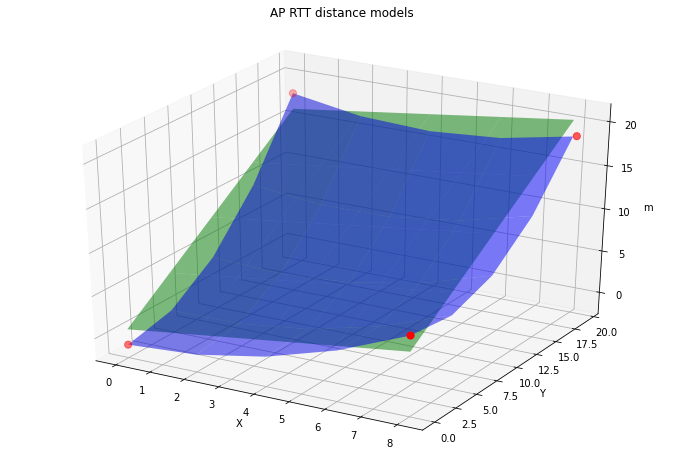

In [42]:
#@title ##Surface Fitting Models Plot
ap_selected = "Google Azul"  #@param ['Google Blanco', 'Linksys 1', 'Google Azul', 'Linksys 2', 'Google Rojo', 'Linksys 3', 'Google Verde']
sample = 8 #@param {type:"slider", min:0, max:100, step:1}

try:
  ap_indexes[ap_selected]
except:
  ap_selected = ap_labels[0]

fig = plt.figure(figsize=(12,8))

ax = fig.gca(projection='3d')

l1 = ax.plot_surface(X, Y, Z_1[int(ap_indexes[ap_selected]),sample], rstride=1, cstride=1, alpha=0.5, label='linear', color='g')
l2 = ax.plot_surface(X, Y, Z_2[int(ap_indexes[ap_selected]),sample], rstride=1, cstride=1, alpha=0.5, label='quadratic', color='b')

ax.scatter(L_ap[:,0], L_ap[:,1], ap_obs[:,int(ap_indexes[ap_selected]),sample], c='r', s=50)

plt.xlabel('X')
plt.ylabel('Y')
ax.set_zlabel('m')
ax.axis('auto')

line_labels = ["AP locations","Linear", "Quadratic"]

#ax.plot([0], [0], d_RTT[:,int(ap_indexes[ap_selected])][0], color="red", marker='o', linewidth=0)[0]
#ax.plot([0], [0], color="green")[0]
#ax.plot([0], [0], color="blue")[0]

#fig.legend(labels=line_labels,loc="upper right",borderaxespad=4)

plt.title('AP RTT distance models', pad=40)
plt.show()

##Mean RTT Distance vectors

In [43]:
"""
Mean RTT distance values at VRPs
    _1 --> Order 1 surface fit
    _2 --> Order 2 surface fit
"""

fit_1 = np.reshape(Z_1, (n_ap, 100, n_points, 1))
fit_2 = np.reshape(Z_2, (n_ap, 100, n_points, 1))

"""
Mean RTT observations between target AP and the rest
"""
m_ap_1 = np.array([fit_1[:, i, points, :] for (i) in np.linspace(0, 100 - 1, 100).astype(int)])
m_ap_2 = np.array([fit_2[:, i, points, :] for (i) in np.linspace(0, 100 - 1, 100).astype(int)])

"""
Reference points vector
"""
vrp_pts = np.delete(np.linspace(0, n_points - 1, n_points).astype(int), points, 0)

"""
Mean RTT observations between target AP and VRPs
"""
m_vrp_1 = np.array([fit_1[:, i, vrp_pts, :] for (i) in np.linspace(0, 100 - 1, 100).astype(int)])
m_vrp_2 = np.array([fit_2[:, i, vrp_pts, :] for (i) in np.linspace(0, 100 - 1, 100).astype(int)])

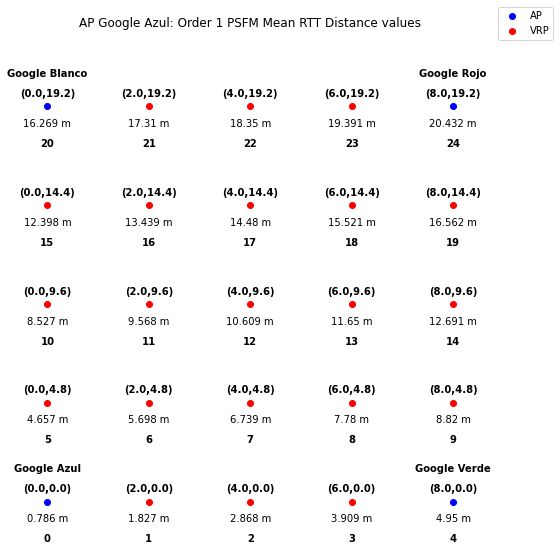

In [44]:
#@title ##Order 1 PSFM Mean RTT Distance Plot
ap_selected = "Google Azul"  #@param ['Google Blanco', 'Linksys 1', 'Google Azul', 'Linksys 2', 'Google Rojo', 'Linksys 3', 'Google Verde']
sample = 8 #@param {type:"slider", min:0, max:100, step:1}

try:
  ap_indexes[ap_selected]
except:
  ap_selected = ap_labels[0]

plt.figure(figsize=(8,8))

plt.scatter(coordinates_ap[:,0], coordinates_ap[:,1], c='b')
plt.scatter(coordinates_vrp[:,0], coordinates_vrp[:,1], c='r')

plt.legend(labels=['AP','VRP'],loc="upper right",borderaxespad=-8)
plt.title('AP '+ap_selected+': Order 1 PSFM Mean RTT Distance values',pad=60)
plt.axis('off')

for x,y,z in zip(coordinates[:,0], coordinates[:,1], np.linspace(0, n_points - 1, n_points).astype(int)):
    label = f"{fit_1[int(ap_indexes[ap_selected]),sample,z][0].round(3)} m"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-20), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

for x,y,z in zip(coordinates[:,0],coordinates[:,1], np.linspace(0, n_points - 1, n_points).astype(int)):
    label = f"({locations[z,0]},{locations[z,1]})"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center',
                 weight='bold') # horizontal alignment can be left, right or center

    label = f"{z}"

    plt.annotate(label, # this is the text
                  (x,y), # this is the point to label
                  textcoords="offset points", # how to position the text
                  xytext=(0,-40), # distance from text to points (x,y)
                  ha='center',
                  weight='bold') # horizontal alignment can be left, right or center

for x,y,z in zip(coordinates_ap[:,0],coordinates_ap[:,1], np.linspace(0, n_ap - 1, n_ap).astype(int)):

    label = f"{ap_labels[z]}"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,30), # distance from text to points (x,y)
                 ha='center', # horizontal alignment can be left, right or center
                 weight='bold')

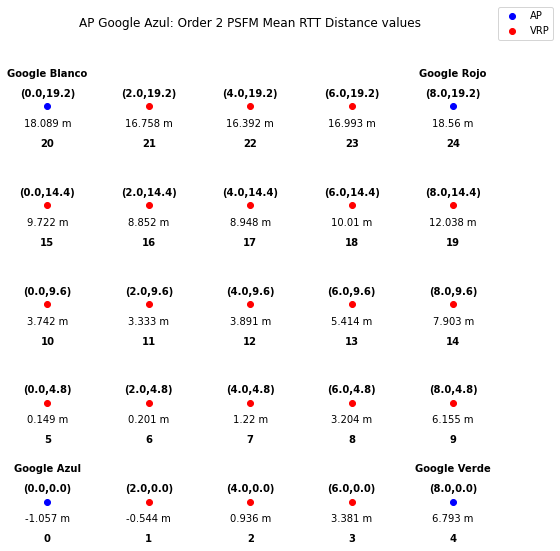

In [45]:
#@title ##Order 2 PSFM Mean RTT Distance Plot
ap_selected = "Google Azul"  #@param ['Google Blanco', 'Linksys 1', 'Google Azul', 'Linksys 2', 'Google Rojo', 'Linksys 3', 'Google Verde']
sample = 8 #@param {type:"slider", min:0, max:100, step:1}

try:
  ap_indexes[ap_selected]
except:
  ap_selected = ap_labels[0]

plt.figure(figsize=(8,8))

plt.scatter(coordinates_ap[:,0], coordinates_ap[:,1], c='b')
plt.scatter(coordinates_vrp[:,0], coordinates_vrp[:,1], c='r')

plt.legend(labels=['AP','VRP'],loc="upper right",borderaxespad=-8)
plt.title('AP '+ap_selected+': Order 2 PSFM Mean RTT Distance values',pad=60)
plt.axis('off')

for x,y,z in zip(coordinates[:,0], coordinates[:,1], np.linspace(0, n_points - 1, n_points).astype(int)):
    label = f"{fit_2[int(ap_indexes[ap_selected]),sample,z][0].round(3)} m"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-20), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

for x,y,z in zip(coordinates[:,0],coordinates[:,1], np.linspace(0, n_points - 1, n_points).astype(int)):
    label = f"({locations[z,0]},{locations[z,1]})"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center',
                 weight='bold') # horizontal alignment can be left, right or center

    label = f"{z}"

    plt.annotate(label, # this is the text
                  (x,y), # this is the point to label
                  textcoords="offset points", # how to position the text
                  xytext=(0,-40), # distance from text to points (x,y)
                  ha='center',
                  weight='bold') # horizontal alignment can be left, right or center

for x,y,z in zip(coordinates_ap[:,0],coordinates_ap[:,1], np.linspace(0, n_ap - 1, n_ap).astype(int)):

    label = f"{ap_labels[z]}"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,30), # distance from text to points (x,y)
                 ha='center', # horizontal alignment can be left, right or center
                 weight='bold')

#Gaussian Process Regression

##Kernel definition

In [46]:
"""
Gaussian Process Kernel definition

Kernel parameters:
    - L --> Length Scale
    - sigma_f --> Constant Kernel Amplitude
"""

def kernel_function(x, y, sigma_f=1, l=1):

    """ Squared Exponential kernel function """
    kernel = sigma_f * np.exp(- (np.linalg.norm(x - y)**2) / (2 * l**2))
    return kernel

##Hyperparameter optimization

In [47]:
"""
Hyperparameter optimization of sigma_f and length-scale

    loc --> AP locations
    mean --> RTT distance observations between APs
"""
def gp_fit(loc, mean):
    '''
    Clear nan values
    '''
    for index, pos in enumerate(mean):
      if math.isnan(pos):
        loc = np.delete(loc, index, 0)
        mean = np.delete(mean,index)

    gp.fit(loc, mean)

    l = gp.kernel_.get_params().get('k2__length_scale')
    sigma_f = gp.kernel_.get_params().get('k1__constant_value')
    return l, sigma_f

In [48]:
"""
Gaussian Process Fit using scikit-learn GPR
"""
sigma_n = 0.0

kernel = ConstantKernel(constant_value=100.0,constant_value_bounds=(1e-3, 1e3)) \
            * RBF(length_scale=10.0, length_scale_bounds=(1e-3, 1e3))

gp = GaussianProcessRegressor(kernel=kernel, alpha=sigma_n**2, n_restarts_optimizer=10)

#hyper_params = np.array([gp_fit(L_ap, ap_obs[:,i,8]) for (i) in np.linspace(0, n_ap - 1, n_ap).astype(int)])
hyper_params = np.array([np.array([gp_fit(L_ap, ap_obs[:,j,i]) 
                      for (i) in np.linspace(0, 100 - 1, 100).astype(int)]) 
                      for (j) in np.linspace(0, n_ap - 1, n_ap).astype(int)]) 

In [49]:
print(hyper_params[:,8])

[[ 14.93914749 166.47957829]
 [ 14.7025477  153.7432269 ]
 [ 14.66415885 148.84504862]
 [ 13.56630026 173.416707  ]]


##GPR Class definition

### Handles the required parameters for each GPR interpolation

####Parameters:

*   **K (ndarray):** Covariance matrix between AP locations
*   **K_star2 (ndarray):** Covariance matrix between VRP locations
*   **K_star (ndarray):** Covariance matrix between each AP location and each VRP location
*   **m_ap (ndarray):** Mean RTT distance values at AP locations from fitting model
*   **m_vrp (ndarray):** Mean RTT distance values at VRP locations from fitting model

In [50]:
class Regressor:
    def __init__(self, _K, _K_star2, _K_star, _m_ap, _m_vrp, _m_ap2, _m_vrp2):
        self.K = _K
        self.K_star2 = _K_star2
        self.K_star = _K_star
        self.m_ap = _m_ap
        self.m_vrp = _m_vrp
        self.m_ap2 = _m_ap2
        self.m_vrp2 = _m_vrp2

##GPR Structure Computing

###Compute components of the covariance matrix of the joint distribution
Covariance Matrices Notation:

* K = K(L_ap, L_ap) 
* K_star = K(L_vrp, L_ap)
* K_star2 = K(L_vrp, L_vrp)

In [71]:
def compute_k_matrix(loc, sigma_f=1, l=1):
    """
    Compute components of the covariance matrix of the joint distribution.
    
    We follow the notation:
        - K = K(L, L)
    """

    K = [kernel_function(i, j, sigma_f=sigma_f, l=l) for (i, j) in itertools.product(loc, loc)]
    K = np.array(K).reshape(n_ap, n_ap)

    return K

In [60]:
def compute_cov_matrices(L_ap, L_vrp, sigma_f=1, l=1):
    """
    Compute components of the covariance matrix of the joint distribution.
    
    We follow the notation:
    
        - K = K(L, L) 
        - K_star = K(L^*, L)
        - K_star2 = K(L^*, L^*)
    """
    n = L_ap.shape[0]
    n_star = L_vrp.shape[0]

    K = [kernel_function(i, j, sigma_f=sigma_f, l=l) for (i, j) in itertools.product(L_ap, L_ap)]

    K = np.array(K).reshape(n, n)
    
    K_star2 = [kernel_function(i, j, sigma_f=sigma_f, l=l) for (i, j) in itertools.product(L_vrp, L_vrp)]

    K_star2 = np.array(K_star2).reshape(n_star, n_star)
    
    K_star = [kernel_function(i, j, sigma_f=sigma_f, l=l) for (i, j) in itertools.product(L_vrp, L_ap)]

    K_star = np.array(K_star).reshape(n_star, n)
    
    return (K, K_star2, K_star)

In [89]:
k_array = np.array([np.array([compute_k_matrix(L_ap, sigma_f=hyper_params[j,i][1], l=hyper_params[j,i][0])
                                  for (i) in np.linspace(0, 100 - 1, 100).astype(int)])
                                  for (j) in np.linspace(0, n_ap - 1, n_ap).astype(int)])
print(k_array[0,8])
print(k_array.shape)
#k_array[0] = compute_k_matrix(L_ap, sigma_f=hyper_params[0,0][1], l=hyper_params[0,0][0])

"""
for i in np.linspace(0, n_ap - 1, n_ap).astype(int):
  for j in np.linspace(0, 100 - 1, 90).astype(int):
    a, b, c = compute_cov_matrices(L_ap, L_vrp, sigma_f=hyper_params[0,0][1], l=hyper_params[0,0][0])
"""
print(k_array.shape)

[[166.47957829 144.2415641   72.89246441  62.92824155]
 [144.2415641  166.47957829  63.15563258  72.89083137]
 [ 72.89246441  63.15563258 166.47957829 143.72222423]
 [ 62.92824155  72.89083137 143.72222423 166.47957829]]
(4, 100, 4, 4)
(4, 100, 4, 4)


##Covariance matrices and regressor objects computing:

- Covariance matrices: K, K_star, K_star2
- Mean distance values: m_ap, m_vrp

 

In [52]:
"""
Covariance matrices and regressor objects computing:

    - Covariance matrices: K, K_star, K_star2
    - Mean distance values: m_ap, m_vrp 
"""

list = []

for i in np.linspace(0, n_ap - 1, n_ap).astype(int):
    a, b, c = compute_cov_matrices(L_ap, L_vrp, sigma_f=hyper_params[i][1], l=hyper_params[i][0])
    gpr = Regressor(a,b,c,m_ap_1[i],m_vrp_1[i],m_ap_2[i],m_vrp_2[i])
    list.append(gpr)

ValueError: ignored

In [ ]:
#@title ##Multivariate Gaussian Process Dimension Check
ap_selected = "Linksys 1"  #@param ['Google Blanco', 'Linksys 1', 'Google Azul', 'Linksys 2', 'Google Rojo', 'Linksys 3', 'Google Verde']

try:
  ap_indexes[ap_selected]
except:
  ap_selected = ap_labels[0]
  
"""
Multivariate Joint Distribution Check: G matrix
"""

n = L_ap.shape[0]
n_star = L_vrp.shape[0]

a = np.concatenate((list[int(ap_indexes[ap_selected])].K + (sigma_n**2)*np.eye(n), list[int(ap_indexes[ap_selected])].K_star), axis=0)
print(a.shape)
b = np.concatenate((list[int(ap_indexes[ap_selected])].K_star.T, list[int(ap_indexes[ap_selected])].K_star2), axis=0)
print(b.shape)
G = np.concatenate((a, b), axis=1)
print(G.shape)
G.shape == (n + n_star, n + n_star)

In [ ]:
#@title ##Covariance Matrices Plot
ap_selected = "Linksys 1"  #@param ['Google Blanco', 'Linksys 1', 'Google Azul', 'Linksys 2', 'Google Rojo', 'Linksys 3', 'Google Verde']

try:
  ap_indexes[ap_selected]
except:
  ap_selected = ap_labels[0]
  
"""
Kernel Covariance Matrix K(L,L)
"""
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(data=list[int(ap_indexes[ap_selected])].K, cmap='Blues', ax=ax)
ax.set(title='AP '+ap_selected+' : Components of the Kernel Covariance Matrix K(L,L)')

"""
Kernel Covariance Matrix K(L*,L*)
"""
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(data=list[int(ap_indexes[ap_selected])].K_star2, cmap='Blues', ax=ax)
ax.set(title='AP '+ap_selected+' : Components of the Kernel Covariance Matrix K(L*,L*)')

"""
Kernel Covariance Matrix K(L*,L)
"""
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(data=list[int(ap_indexes[ap_selected])].K_star, cmap='Blues', ax=ax)
ax.set(title='AP '+ap_selected+' : Components of the Kernel Covariance Matrix K(L*,L)')
print("\nCovariance matrices: \n\n")

#PSFM GPR Interpolation

##Interpolation Computing

In [ ]:
def psfm_gpr_parameters(m, m_star, d, K, K_star2, K_star, sigma_n):
    
    """Compute gaussian regression parameters."""

    n = K.shape[0]
    n_star = K_star.shape[0]
    
    # Mean.
    s_bar_star = (m_star.reshape([n_star, 1]) 
        + np.dot(K_star, np.dot(np.linalg.inv(K + (sigma_n**2)*np.eye(n)), d.reshape([n, 1]) - m.reshape([n, 1]))))
    # Covariance.
    cov_s_star = K_star2 - np.dot(K_star, np.dot(np.linalg.inv(K + (sigma_n**2)*np.eye(n)), K_star.T))
    
    return (s_bar_star.reshape(n_star), cov_s_star)

In [ ]:
def zero_mean_gpr_parameters(d, K, K_star2, K_star, sigma_n):
    
    """Compute gaussian regression parameters."""

    n = K.shape[0]
    n_star = K_star.shape[0]

    # Mean.
    s_bar_star = np.dot(K_star, np.dot(np.linalg.inv(K + (sigma_n**2)*np.eye(n)), d.reshape([n, 1])))
    # Covariance.
    cov_s_star = K_star2 - np.dot(K_star, np.dot(np.linalg.inv(K + (sigma_n**2)*np.eye(n)), K_star.T))
    
    return (s_bar_star.reshape(n_star), cov_s_star)

In [ ]:
"""
Zero-Mean Gaussian Process interpolations
"""
n = L_ap.shape[0]
n_star = L_vrp.shape[0]

means = np.empty((n, n_star, 1))
variances = np.empty((n, n_star, 1))

for i in np.linspace(0, n_ap - 1, n_ap).astype(int):

    s_bar_star, cov_s_star = zero_mean_gpr_parameters(d_RTT[:,i], list[i].K, list[i].K_star2, list[i].K_star, sigma_n)
    var_s_star = np.diag(cov_s_star)

    means[i,:,:] = s_bar_star.reshape(n_star,1)
    variances[i,:,:] = var_s_star.reshape(n_star,1)

In [ ]:
"""
Order 1 PSFM Gaussian Process interpolations
"""
means_psfm = np.empty((n, n_star, 1))

for i in np.linspace(0, n_ap - 1, n_ap).astype(int):
  
    s_bar_star, cov_s_star = psfm_gpr_parameters(list[i].m_ap,list[i].m_vrp, d_RTT[:,i], list[i].K, list[i].K_star2, list[i].K_star, sigma_n)
    means_psfm[i,:,:] = s_bar_star.reshape(n_star,1)

In [ ]:
"""
Order 2 PSFM Gaussian Process interpolations
"""
means_psfm2 = np.empty((n, n_star, 1))

for i in np.linspace(0, n_ap - 1, n_ap).astype(int):
  
    s_bar_star, cov_s_star = psfm_gpr_parameters(list[i].m_ap2,list[i].m_vrp2, d_RTT[:,i], list[i].K, list[i].K_star2, list[i].K_star, sigma_n)
    means_psfm2[i,:,:] = s_bar_star.reshape(n_star,1)

##Interpolation Plots

In [ ]:
#@title ##Zero-Mean GPR
ap_selected = "Google Rojo"  #@param ['Google Blanco', 'Linksys 1', 'Google Azul', 'Linksys 2', 'Google Rojo', 'Linksys 3', 'Google Verde']

try:
  ap_indexes[ap_selected]
except:
  ap_selected = ap_labels[0]
  
"""
Zero Mean Gaussian Process interpolation:
    
    s_bar_star --> Mean estimated value for each VRP
    cov_s_star --> Posterior covariance matrix
    var_s_star --> VRP estimation variance
"""

plt.figure(figsize=(9,6))

plt.scatter(coordinates_ap[:,0], coordinates_ap[:,1], c='b')
plt.scatter(coordinates_vrp[:,0], coordinates_vrp[:,1], c='r')

plt.legend(labels=['AP','VRP'],loc="upper right",borderaxespad=-8)
plt.title('AP '+ap_selected+' : Zero Mean Gaussian Process interpolation',pad=60)
plt.axis('off')

for x,y,z in zip(coordinates_ap[:,0], coordinates_ap[:,1], d_RTT[:,int(ap_indexes[ap_selected])]):
    label = f"{z.round(3)} m"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-20), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

for x in range(len(means[int(ap_indexes[ap_selected])])):
    label = f"{means[int(ap_indexes[ap_selected])][x,0].round(3)} +- {variances[int(ap_indexes[ap_selected])][x,0].round(3)} m"

    plt.annotate(label, # this is the text
                 (coordinates_vrp[x,0],coordinates_vrp[x,1]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-20), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

for x,y,z in zip(coordinates_ap[:,0],coordinates_ap[:,1], np.linspace(0, n_ap - 1, n_ap).astype(int)):

    label = f"{ap_labels[z]}"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,30), # distance from text to points (x,y)
                 ha='center', # horizontal alignment can be left, right or center
                 weight='bold')

for x,y,z in zip(coordinates[:,0],coordinates[:,1], np.linspace(0, n_points - 1, n_points).astype(int)):
    label = f"({locations[z,0]},{locations[z,1]})"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center',
                 weight='bold') # horizontal alignment can be left, right or center

In [ ]:
#@title ##First Order PSFM GPR
ap_selected = "Google Azul"  #@param ['Google Blanco', 'Linksys 1', 'Google Azul', 'Linksys 2', 'Google Rojo', 'Linksys 3', 'Google Verde']

try:
  ap_indexes[ap_selected]
except:
  ap_selected = ap_labels[0]

"""
First Order PSFM Gaussian Process interpolation:
    
    s_bar_star --> Mean estimated value for each VRP
    cov_s_star --> Posterior covariance matrix
    var_s_star --> VRP estimation variance
"""

plt.figure(figsize=(9,6))

plt.scatter(coordinates_ap[:,0], coordinates_ap[:,1], c='b')
plt.scatter(coordinates_vrp[:,0], coordinates_vrp[:,1], c='r')

plt.legend(labels=['AP','VRP'],loc="upper right",borderaxespad=-8)
plt.title('AP '+ap_selected+' : First Order PSFM Gaussian Process interpolation',pad=60)
plt.axis('off')

for x,y,z in zip(coordinates_ap[:,0], coordinates_ap[:,1], d_RTT[:,int(ap_indexes[ap_selected])]):
    label = f"{z.round(3)} m"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-20), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

for x in range(len(means_psfm[int(ap_indexes[ap_selected])])):
    label = f"{means_psfm[int(ap_indexes[ap_selected])][x,0].round(3)} +- {variances[int(ap_indexes[ap_selected])][x,0].round(3)} m"

    plt.annotate(label, # this is the text
                 (coordinates_vrp[x,0],coordinates_vrp[x,1]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-20), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

for x,y,z in zip(coordinates_ap[:,0],coordinates_ap[:,1], np.linspace(0, n_ap - 1, n_ap).astype(int)):

    label = f"{ap_labels[z]}"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,30), # distance from text to points (x,y)
                 ha='center', # horizontal alignment can be left, right or center
                 weight='bold')

for x,y,z in zip(coordinates[:,0],coordinates[:,1], np.linspace(0, n_points - 1, n_points).astype(int)):
    label = f"({locations[z,0]},{locations[z,1]})"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center',
                 weight='bold') # horizontal alignment can be left, right or center

In [ ]:
#@title ##Second Order PSFM GPR
ap_selected = "Google Azul"  #@param ['Google Blanco', 'Linksys 1', 'Google Azul', 'Linksys 2', 'Google Rojo', 'Linksys 3', 'Google Verde']

try:
  ap_indexes[ap_selected]
except:
  ap_selected = ap_labels[0]

"""
Second Order PSFM Gaussian Process interpolation:
    
    s_bar_star --> Mean estimated value for each VRP
    cov_s_star --> Posterior covariance matrix
    var_s_star --> VRP estimation variance
"""

plt.figure(figsize=(9,6))

plt.scatter(coordinates_ap[:,0], coordinates_ap[:,1], c='b')
plt.scatter(coordinates_vrp[:,0], coordinates_vrp[:,1], c='r')

plt.legend(labels=['AP','VRP'],loc="upper right",borderaxespad=-8)
plt.title('AP '+ap_selected+' : Second Order PSFM Gaussian Process interpolation',pad=60)
plt.axis('off')

for x,y,z in zip(coordinates_ap[:,0], coordinates_ap[:,1], d_RTT[:,int(ap_indexes[ap_selected])]):
    label = f"{z.round(3)} m"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-20), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

for x in range(len(means_psfm2[int(ap_indexes[ap_selected])])):
    label = f"{means_psfm2[int(ap_indexes[ap_selected])][x,0].round(3)} +- {variances[int(ap_indexes[ap_selected])][x,0].round(3)} m"

    plt.annotate(label, # this is the text
                 (coordinates_vrp[x,0],coordinates_vrp[x,1]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-20), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

for x,y,z in zip(coordinates_ap[:,0],coordinates_ap[:,1], np.linspace(0, n_ap - 1, n_ap).astype(int)):

    label = f"{ap_labels[z]}"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,30), # distance from text to points (x,y)
                 ha='center', # horizontal alignment can be left, right or center
                 weight='bold')

for x,y,z in zip(coordinates[:,0],coordinates[:,1], np.linspace(0, n_points - 1, n_points).astype(int)):
    label = f"({locations[z,0]},{locations[z,1]})"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center',
                 weight='bold') # horizontal alignment can be left, right or center

#Fingerprinting Database Construction

In [ ]:
#@title ##Zero Mean GPR Fingerprinting Database plot

plt.figure(figsize=(16,18))

plt.scatter(coordinates_ap[:,0], coordinates_ap[:,1], c='b')
plt.scatter(coordinates_vrp[:,0], coordinates_vrp[:,1], c='r')

plt.legend(labels=['AP','VRP'],loc="upper right",borderaxespad=-8)
plt.axis('off')

for x in range(len(d_RTT[:,0])):
    for y in range(len(d_RTT[:,0])):
        label = f"{ap_labels[y]}: {d_RTT[x,y].round(3)} m"

        plt.annotate(label, # this is the text
                    (coordinates_ap[x,0],coordinates_ap[x,1]), # this is the point to label
                    textcoords="offset points", # how to position the text
                    xytext=(0,-20-y*20), # distance from text to points (x,y)
                    ha='center') # horizontal alignment can be left, right or center

for x in range(len(means[0])):
    for y in range(len(d_RTT[:,0])):
        label = f"{ap_labels[y]}: {means[:,x,:][y,0].round(3)} +- {variances[:,x,:][y,0].round(3)} m"

        plt.annotate(label, # this is the text
                    (coordinates_vrp[x,0],coordinates_vrp[x,1]), # this is the point to label
                    textcoords="offset points", # how to position the text
                    xytext=(0,-20-y*20), # distance from text to points (x,y)
                    ha='center') # horizontal alignment can be left, right or center


for x,y,z in zip(coordinates_ap[:,0],coordinates_ap[:,1], np.linspace(0, n_ap - 1, n_ap).astype(int)):

    label = f"{ap_labels[z]}"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,30), # distance from text to points (x,y)
                 ha='center', # horizontal alignment can be left, right or center
                 weight='bold')


for x,y,z in zip(coordinates[:,0],coordinates[:,1], np.linspace(0, n_points - 1, n_points).astype(int)):
    label = f"({locations[z,0]},{locations[z,1]})"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center',
                 weight='bold') # horizontal alignment can be left, right or center

In [ ]:
#@title ##First Order PSFM GPR Fingerprinting Database plot

plt.figure(figsize=(16,18))

plt.scatter(coordinates_ap[:,0], coordinates_ap[:,1], c='b')
plt.scatter(coordinates_vrp[:,0], coordinates_vrp[:,1], c='r')

plt.legend(labels=['AP','VRP'],loc="upper right",borderaxespad=-8)
plt.axis('off')

for x in range(len(d_RTT[:,0])):
    for y in range(len(d_RTT[:,0])):
        label = f"{ap_labels[y]}: {d_RTT[x,y].round(3)} m"

        plt.annotate(label, # this is the text
                    (coordinates_ap[x,0],coordinates_ap[x,1]), # this is the point to label
                    textcoords="offset points", # how to position the text
                    xytext=(0,-20-y*20), # distance from text to points (x,y)
                    ha='center') # horizontal alignment can be left, right or center

for x in range(len(means_psfm[0])):
    for y in range(len(d_RTT[:,0])):
        label = f"{ap_labels[y]}: {means_psfm[:,x,:][y,0].round(3)} +- {variances[:,x,:][y,0].round(3)} m"

        plt.annotate(label, # this is the text
                    (coordinates_vrp[x,0],coordinates_vrp[x,1]), # this is the point to label
                    textcoords="offset points", # how to position the text
                    xytext=(0,-20-y*20), # distance from text to points (x,y)
                    ha='center') # horizontal alignment can be left, right or center

for x,y,z in zip(coordinates_ap[:,0],coordinates_ap[:,1], np.linspace(0, n_ap - 1, n_ap).astype(int)):

    label = f"{ap_labels[z]}"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,30), # distance from text to points (x,y)
                 ha='center', # horizontal alignment can be left, right or center
                 weight='bold')

for x,y,z in zip(coordinates[:,0],coordinates[:,1], np.linspace(0, n_points - 1, n_points).astype(int)):
    label = f"({locations[z,0]},{locations[z,1]})"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center',
                 weight='bold') # horizontal alignment can be left, right or center

In [ ]:
#@title ##Second Order PSFM GPR Fingerprinting Database plot

plt.figure(figsize=(16,18))

plt.scatter(coordinates_ap[:,0], coordinates_ap[:,1], c='b')
plt.scatter(coordinates_vrp[:,0], coordinates_vrp[:,1], c='r')

plt.legend(labels=['AP','VRP'],loc="upper right",borderaxespad=-8)
plt.axis('off')

for x in range(len(d_RTT[:,0])):
    for y in range(len(d_RTT[:,0])):
        label = f"{ap_labels[y]}: {d_RTT[x,y].round(3)} m"

        plt.annotate(label, # this is the text
                    (coordinates_ap[x,0],coordinates_ap[x,1]), # this is the point to label
                    textcoords="offset points", # how to position the text
                    xytext=(0,-20-y*20), # distance from text to points (x,y)
                    ha='center') # horizontal alignment can be left, right or center

for x in range(len(means_psfm2[0])):
    for y in range(len(d_RTT[:,0])):
        label = f"{ap_labels[y]}: {means_psfm2[:,x,:][y,0].round(3)} +- {variances[:,x,:][y,0].round(3)} m"

        plt.annotate(label, # this is the text
                    (coordinates_vrp[x,0],coordinates_vrp[x,1]), # this is the point to label
                    textcoords="offset points", # how to position the text
                    xytext=(0,-20-y*20), # distance from text to points (x,y)
                    ha='center') # horizontal alignment can be left, right or center

for x,y,z in zip(coordinates_ap[:,0],coordinates_ap[:,1], np.linspace(0, n_ap - 1, n_ap).astype(int)):

    label = f"{ap_labels[z]}"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,30), # distance from text to points (x,y)
                 ha='center', # horizontal alignment can be left, right or center
                 weight='bold')

for x,y,z in zip(coordinates[:,0],coordinates[:,1], np.linspace(0, n_points - 1, n_points).astype(int)):
    label = f"({locations[z,0]},{locations[z,1]})"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center',
                 weight='bold') # horizontal alignment can be left, right or center

#Data validation

In [ ]:
"""
Dataset Split VRP's
"""
vrp_meas = np.empty((n_vrp, n_ap, 100))

df.sort_values(ap_mac)
for count, row in enumerate(L_vrp):
  aux = df.loc[(df['y'] == row[0]) & (df['x'] == row[1]) & (df['model'] == 'Pixel 3a')]
  aux = aux[ap_mac].values
  aux = aux.T
  vrp_meas[count,:,:] = aux

##Scoring Computing

###RTT Distance Estimation Accuracy

In [ ]:
"""
Zero-Mean GPR Scoring by AP
"""
err = np.empty((n, n_star, 1))
std_dev = np.empty((n, n_star, 1))
for i in np.linspace(0, n_ap - 1, n_ap).astype(int):
  for j, row in enumerate(means[i]):
    diff = row - vrp_meas[j,i,:]
    err[i,j] = abs(np.nanmean(diff))
    std_dev[i,j] = np.nanstd(diff)

In [ ]:
"""
First Order PSFM GPR Scoring by AP
"""
err_psfm = np.empty((n, n_star, 1))
for i in np.linspace(0, n_ap - 1, n_ap).astype(int):
  for j, row in enumerate(means_psfm[i]):
    diff = row - vrp_meas[j,i,:]
    err_psfm[i,j] = abs(np.nanmean(diff))

In [ ]:
"""
Second Order PSFM GPR Scoring by AP
"""
err_psfm2 = np.empty((n, n_star, 1))
for i in np.linspace(0, n_ap - 1, n_ap).astype(int):
  for j, row in enumerate(means_psfm2[i]):
    diff = row - vrp_meas[j,i,:]
    err_psfm2[i,j] = abs(np.nanmean(row - vrp_meas[j,i,:]))

##Scoring Plots

###RTT Distance Estimation Accuracy

In [ ]:
#@title ##Zero-Mean GPR
ap_selected = "Google Blanco"  #@param ['Google Blanco', 'Linksys 1', 'Google Azul', 'Linksys 2', 'Google Rojo', 'Linksys 3', 'Google Verde']

try:
  ap_indexes[ap_selected]
except:
  ap_selected = ap_labels[0]
  
"""
Zero Mean Gaussian Process Scoring:
    err --> Mean RTT distance error at each VRP
"""

plt.figure(figsize=(9,6))

plt.scatter(coordinates_ap[:,0], coordinates_ap[:,1], c='b')
plt.scatter(coordinates_vrp[:,0], coordinates_vrp[:,1], c='r')

plt.legend(labels=['AP','VRP'],loc="upper right",borderaxespad=-8)
plt.title('AP '+ap_selected+' : Zero Mean Gaussian Process Scoring',pad=60)
plt.axis('off')

for x in range(len(err[int(ap_indexes[ap_selected]),:])):
    label = f"Mean: {err[int(ap_indexes[ap_selected]),x][0].round(3)}"

    plt.annotate(label, # this is the text
                 (coordinates_vrp[x,0],coordinates_vrp[x,1]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-20), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

for x in range(len(std_dev[int(ap_indexes[ap_selected]),:])):
    label = f"Std: {std_dev[int(ap_indexes[ap_selected]),x][0].round(3)}"

    plt.annotate(label, # this is the text
                 (coordinates_vrp[x,0],coordinates_vrp[x,1]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-35), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

for x,y,z in zip(coordinates_ap[:,0],coordinates_ap[:,1], np.linspace(0, n_ap - 1, n_ap).astype(int)):

    label = f"{ap_labels[z]}"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-20), # distance from text to points (x,y)
                 ha='center', # horizontal alignment can be left, right or center
                 weight='bold')

for x,y,z in zip(coordinates[:,0],coordinates[:,1], np.linspace(0, n_points - 1, n_points).astype(int)):
    label = f"({locations[z,0]},{locations[z,1]})"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center',
                 weight='bold') # horizontal alignment can be left, right or center

In [ ]:
#@title ##First Order PSFM GPR
ap_selected = "Google Blanco"  #@param ['Google Blanco', 'Linksys 1', 'Google Azul', 'Linksys 2', 'Google Rojo', 'Linksys 3', 'Google Verde']

try:
  ap_indexes[ap_selected]
except:
  ap_selected = ap_labels[0]
  
"""
Zero Mean Gaussian Process Scoring:
    err --> Mean RTT distance error at each VRP
"""

plt.figure(figsize=(9,6))

plt.scatter(coordinates_ap[:,0], coordinates_ap[:,1], c='b')
plt.scatter(coordinates_vrp[:,0], coordinates_vrp[:,1], c='r')

plt.legend(labels=['AP','VRP'],loc="upper right",borderaxespad=-8)
plt.title('AP '+ap_selected+' : Zero Mean Gaussian Process Scoring',pad=60)
plt.axis('off')

for x in range(len(err_psfm[int(ap_indexes[ap_selected]),:])):
    label = f"Mean: {err_psfm[int(ap_indexes[ap_selected]),x][0].round(3)}"

    plt.annotate(label, # this is the text
                 (coordinates_vrp[x,0],coordinates_vrp[x,1]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-20), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

for x in range(len(std_dev[int(ap_indexes[ap_selected]),:])):
    label = f"Std: {std_dev[int(ap_indexes[ap_selected]),x][0].round(3)}"

    plt.annotate(label, # this is the text
                 (coordinates_vrp[x,0],coordinates_vrp[x,1]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-35), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

for x,y,z in zip(coordinates_ap[:,0],coordinates_ap[:,1], np.linspace(0, n_ap - 1, n_ap).astype(int)):

    label = f"{ap_labels[z]}"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-20), # distance from text to points (x,y)
                 ha='center', # horizontal alignment can be left, right or center
                 weight='bold')

for x,y,z in zip(coordinates[:,0],coordinates[:,1], np.linspace(0, n_points - 1, n_points).astype(int)):
    label = f"({locations[z,0]},{locations[z,1]})"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center',
                 weight='bold') # horizontal alignment can be left, right or center

In [ ]:
#@title ##Second Order PSFM GPR
ap_selected = "Google Blanco"  #@param ['Google Blanco', 'Linksys 1', 'Google Azul', 'Linksys 2', 'Google Rojo', 'Linksys 3', 'Google Verde']

try:
  ap_indexes[ap_selected]
except:
  ap_selected = ap_labels[0]
  
"""
Zero Mean Gaussian Process Scoring:
    err --> Mean RTT distance error at each VRP
"""

plt.figure(figsize=(9,6))

plt.scatter(coordinates_ap[:,0], coordinates_ap[:,1], c='b')
plt.scatter(coordinates_vrp[:,0], coordinates_vrp[:,1], c='r')

plt.legend(labels=['AP','VRP'],loc="upper right",borderaxespad=-8)
plt.title('AP '+ap_selected+' : Zero Mean Gaussian Process Scoring',pad=60)
plt.axis('off')

for x in range(len(err_psfm2[int(ap_indexes[ap_selected]),:])):
    label = f"Mean: {err_psfm2[int(ap_indexes[ap_selected]),x][0].round(3)}"

    plt.annotate(label, # this is the text
                 (coordinates_vrp[x,0],coordinates_vrp[x,1]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-20), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

for x in range(len(std_dev[int(ap_indexes[ap_selected]),:])):
    label = f"Std: {std_dev[int(ap_indexes[ap_selected]),x][0].round(3)}"

    plt.annotate(label, # this is the text
                 (coordinates_vrp[x,0],coordinates_vrp[x,1]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-35), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

for x,y,z in zip(coordinates_ap[:,0],coordinates_ap[:,1], np.linspace(0, n_ap - 1, n_ap).astype(int)):

    label = f"{ap_labels[z]}"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-20), # distance from text to points (x,y)
                 ha='center', # horizontal alignment can be left, right or center
                 weight='bold')

for x,y,z in zip(coordinates[:,0],coordinates[:,1], np.linspace(0, n_points - 1, n_points).astype(int)):
    label = f"({locations[z,0]},{locations[z,1]})"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center',
                 weight='bold') # horizontal alignment can be left, right or center